## 生成式对抗网络 （Generative Adversarial Networks）

这里实现一个在法国深度学习研究者Marc Lelarge课程里提到的生成式对抗网络，PPT地址在：https://mlelarge.github.io/dataflowr-slides/Slides/GAN/index.html

数据集非常有趣，是 double moon dataset，数据特点可以看PPT里的描述

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 这是一个展示数据的函数
def plot_data(ax, X, Y, color = 'bone'):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap=color)

借助于 sklearn.datasets.make_moons 库，生成双半月形的数据，同时把数据点画出来。

可以看出，数据散点呈现两个半月形状。

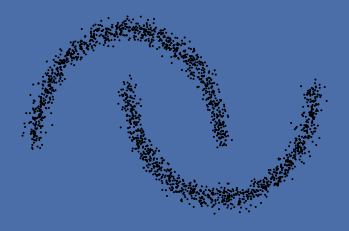

In [0]:
X, y = make_moons(n_samples=2000, noise=0.05)

n_samples = X.shape[0]
Y = np.ones(n_samples)
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
plot_data(ax, X, Y)
plt.show()

## 一个简单的 GAN

生成器和判别器的结构都非常简单，具体如下：
- 生成器： 32 ==> 128 ==> 2
- 判别器： 2 ==> 128 ==> 1

生成器生成的是样本，即一组坐标（x,y），我们希望生成器能够由一组任意的 32组噪声生成座标（x,y）处于两个半月形状上。

判别器输入的是一组座标（x,y），最后一层是sigmoid函数，是一个范围在（0，1）间的数，即样本为真或者假的置信度。如果输入的是真样本，得到的结果尽量接近1；如果输入的是假样本，得到的结果尽量接近0。

In [0]:
import torch.nn as nn

z_dim = 32
hidden_dim = 128

# 定义生成器
net_G = nn.Sequential(
            nn.Linear(z_dim,hidden_dim),
            nn.ReLU(), 
            nn.Linear(hidden_dim, 2))

# 定义判别器
net_D = nn.Sequential(
            nn.Linear(2,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,1),
            nn.Sigmoid())

# 网络放到 GPU 上
net_G = net_G.to(device)
net_D = net_D.to(device)

# 定义网络的优化器
optimizer_G = torch.optim.Adam(net_G.parameters(),lr=0.0001)
optimizer_D = torch.optim.Adam(net_D.parameters(),lr=0.0001)

下面为对抗训练的过程：

In [0]:
batch_size = 50
nb_epochs = 1000

loss_D_epoch = []
loss_G_epoch = []

for e in range(nb_epochs):
    np.random.shuffle(X)
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    loss_G = 0
    loss_D = 0
    for t, real_batch in enumerate(real_samples.split(batch_size)):
        # 固定生成器G，改进判别器D
        # 使用normal_()函数生成一组随机噪声，输入G得到一组样本
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_G(z)
        # 将真、假样本分别输入判别器，得到结果
        D_scores_on_real = net_D(real_batch.to(device))
        D_scores_on_fake = net_D(fake_batch)
        # 优化过程中，假样本的score会越来越小，真样本的score会越来越大，下面 loss 的定义刚好符合这一规律，
        # 要保证loss越来越小，真样本的score前面要加负号
        # 要保证loss越来越小，假样本的score前面是正号（负负得正）
        loss = -torch.mean(torch.log(1-D_scores_on_fake) + torch.log(D_scores_on_real))
        # 梯度清零
        optimizer_D.zero_grad()
        # 反向传播优化
        loss.backward()
        # 更新全部参数
        optimizer_D.step()
        loss_D += loss
                    
        # 固定判别器，改进生成器
        # 生成一组随机噪声，输入生成器得到一组假样本
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_G(z)
        # 假样本输入判别器得到 score
        D_scores_on_fake = net_D(fake_batch)
        # 我们希望假样本能够骗过生成器，得到较高的分数，下面的 loss 定义也符合这一规律
        # 要保证 loss 越来越小，假样本的前面要加负号
        loss = -torch.mean(torch.log(D_scores_on_fake))
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()
        loss_G += loss
    
    if e % 50 ==0:
        print(f'\n Epoch {e} , D loss: {loss_D}, G loss: {loss_G}') 

    loss_D_epoch.append(loss_D)
    loss_G_epoch.append(loss_G)


 Epoch 0 , D loss: 43.565765380859375, G loss: 35.97362518310547

 Epoch 50 , D loss: 53.68849563598633, G loss: 28.474868774414062

 Epoch 100 , D loss: 50.401126861572266, G loss: 36.476417541503906

 Epoch 150 , D loss: 64.80818176269531, G loss: 19.845569610595703

 Epoch 200 , D loss: 50.89078903198242, G loss: 31.878908157348633

 Epoch 250 , D loss: 44.92626953125, G loss: 34.5893669128418

 Epoch 300 , D loss: 55.215030670166016, G loss: 28.980443954467773

 Epoch 350 , D loss: 47.99706268310547, G loss: 32.69681930541992

 Epoch 400 , D loss: 51.698974609375, G loss: 30.255664825439453

 Epoch 450 , D loss: 51.86140441894531, G loss: 31.051939010620117

 Epoch 500 , D loss: 52.52715301513672, G loss: 30.656856536865234

 Epoch 550 , D loss: 53.082332611083984, G loss: 30.390047073364258

 Epoch 600 , D loss: 53.966819763183594, G loss: 30.06268310546875

 Epoch 650 , D loss: 53.64789581298828, G loss: 29.142202377319336

 Epoch 700 , D loss: 54.09611892700195, G loss: 28.8796

显示 loss 的变化情况：

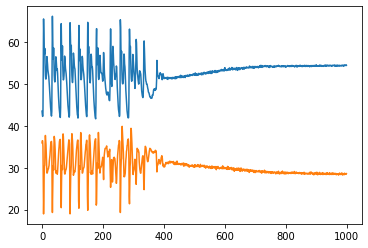

In [0]:
plt.plot(loss_D_epoch)
plt.plot(loss_G_epoch)

利用生成器生成一组假样本，观察是否符合两个半月形状的数据分布：

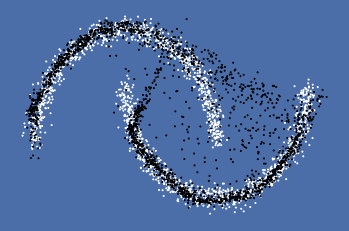

In [0]:
z = torch.empty(n_samples,z_dim).normal_().to(device)
fake_samples = net_G(z)
fake_data = fake_samples.cpu().data.numpy()

fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
all_data = np.concatenate((X,fake_data),axis=0)
Y2 = np.concatenate((np.ones(n_samples),np.zeros(n_samples)))
plot_data(ax, all_data, Y2)
plt.show()

其中，白色的是原来的真实样本，黑色的点是生成器生成的样本。

看起来，效果是不令人满意的。现在把学习率修改为 0.001，batch_size改大到250，再试一次：

In [0]:
# 定义网络的优化器
optimizer_G = torch.optim.Adam(net_G.parameters(),lr=0.001)
optimizer_D = torch.optim.Adam(net_D.parameters(),lr=0.001)

batch_size = 250

loss_D_epoch = []
loss_G_epoch = []

for e in range(nb_epochs):
    np.random.shuffle(X)
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    loss_G = 0
    loss_D = 0
    for t, real_batch in enumerate(real_samples.split(batch_size)):
        # 固定生成器G，改进判别器D
        # 使用normal_()函数生成一组随机噪声，输入G得到一组样本
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_G(z)
        # 将真、假样本分别输入判别器，得到结果
        D_scores_on_real = net_D(real_batch.to(device))
        D_scores_on_fake = net_D(fake_batch)
        # 优化过程中，假样本的score会越来越小，真样本的score会越来越大，下面 loss 的定义刚好符合这一规律，
        # 要保证loss越来越小，真样本的score前面要加负号
        # 要保证loss越来越小，假样本的score前面是正号（负负得正）
        loss = -torch.mean(torch.log(1-D_scores_on_fake) + torch.log(D_scores_on_real))
        # 梯度清零
        optimizer_D.zero_grad()
        # 反向传播优化
        loss.backward()
        # 更新全部参数
        optimizer_D.step()
        loss_D += loss
                    
        # 固定判别器，改进生成器
        # 生成一组随机噪声，输入生成器得到一组假样本
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_G(z)
        # 假样本输入判别器得到 score
        D_scores_on_fake = net_D(fake_batch)
        # 我们希望假样本能够骗过生成器，得到较高的分数，下面的 loss 定义也符合这一规律
        # 要保证 loss 越来越小，假样本的前面要加负号
        loss = -torch.mean(torch.log(D_scores_on_fake))
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()
        loss_G += loss
    
    if e % 50 ==0:
        print(f'\n Epoch {e} , D loss: {loss_D}, G loss: {loss_G}') 

    loss_D_epoch.append(loss_D)
    loss_G_epoch.append(loss_G)


 Epoch 0 , D loss: 11.030909538269043, G loss: 5.618193626403809

 Epoch 50 , D loss: 11.003634452819824, G loss: 5.559389114379883

 Epoch 100 , D loss: 11.044776916503906, G loss: 5.609931945800781

 Epoch 150 , D loss: 11.018218994140625, G loss: 5.7233781814575195

 Epoch 200 , D loss: 11.038992881774902, G loss: 5.636979103088379

 Epoch 250 , D loss: 11.075369834899902, G loss: 5.572358131408691

 Epoch 300 , D loss: 11.091253280639648, G loss: 5.61991024017334

 Epoch 350 , D loss: 11.052449226379395, G loss: 5.668082237243652

 Epoch 400 , D loss: 11.017865180969238, G loss: 5.658195495605469

 Epoch 450 , D loss: 11.050533294677734, G loss: 5.603460788726807

 Epoch 500 , D loss: 11.030721664428711, G loss: 5.616750240325928

 Epoch 550 , D loss: 11.025235176086426, G loss: 5.579407215118408

 Epoch 600 , D loss: 11.074933052062988, G loss: 5.616929531097412

 Epoch 650 , D loss: 11.04503345489502, G loss: 5.591319561004639

 Epoch 700 , D loss: 11.018255233764648, G loss: 5.

非常神奇！ loss 明显减小了，我们再次利用噪声生成一组数据观察一下：

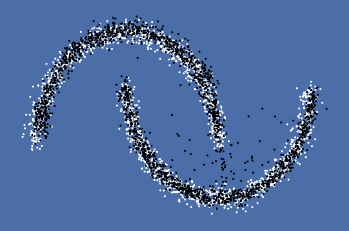

In [0]:
z = torch.empty(n_samples,z_dim).normal_().to(device)
fake_samples = net_G(z)
fake_data = fake_samples.cpu().data.numpy()

fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
all_data = np.concatenate((X,fake_data),axis=0)
Y2 = np.concatenate((np.ones(n_samples),np.zeros(n_samples)))
plot_data(ax, all_data, Y2)
plt.show()

看得出来，随着batch size 的增大， loss 的降低，效果明显改善了~~~ (^_^)

下面我们生成更多的样本观察一下，结果也是非常有趣。

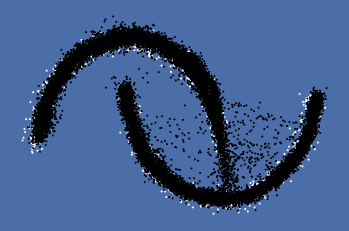

In [0]:
z = torch.empty(10*n_samples,z_dim).normal_().to(device)
fake_samples = net_G(z)
fake_data = fake_samples.cpu().data.numpy()
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
all_data = np.concatenate((X,fake_data),axis=0)
Y2 = np.concatenate((np.ones(n_samples),np.zeros(10*n_samples)))
plot_data(ax, all_data, Y2)
plt.show();